In [3]:
from pathlib import Path
from utilities import ls, crawl
import nibabel as nib
from cloudpathlib import S3Path, S3Client
from dipy.io.image import load_nifti, save_nifti
from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
from dipy.segment.mask import median_otsu
import matplotlib.pyplot as plt
import dipy.reconst.dti as dti
import numpy as np
from scipy import ndimage
from dipy.data import get_sphere
from dipy.direction import peaks_from_model
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram
from fury import actor, colormap
from visualization_utils import generate_anatomical_volume_figure


ModuleNotFoundError: No module named 'cloudpathlib'

In [2]:
# Make the path object:
cache_path = Path('/tmp/cache')

# Just because we have made a cache path object doesn't mean that the directory
# we made exists; here we check if it exists and make the directory if not.
if not cache_path.exists():
    cache_path.mkdir()

In [3]:

client = S3Client(
    local_cache_dir=cache_path,
    no_sign_request=True)

hbn_base_path = S3Path(
    "s3://fcp-indi/",
    client=client)

In [4]:

# bids_path   = hbn_base_path / 'data' / 'Projects' / 'HBN' / 'MRI'/ 'Site-CUNY'
bids_path = hbn_base_path / "data" / "Projects" / "HBN" / "BIDS_curated" 
sub_code = ["sub-NDARAA948VFH", "sub-NDARAB055BPR"]



In [5]:
# Set variables on your file names
bids_ses     = 'HBNsiteRU'
bids_acq_anat= 'HCP'
bids_acq_dwi = '64dir'

# Choose on sub to test
bids_sub_idx = 0 
bids_sub     = f'{sub_code[bids_sub_idx]}'
bids_sub

'sub-NDARAA948VFH'

In [6]:
# Load T1w volume
t1_fname = bids_path / bids_sub / f'ses-{bids_ses}' /'anat' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_anat}_T1w.nii.gz'
t1_data, t1_affine, t1_nii    = load_nifti(t1_fname, return_img=True)

# Set DWI file names
# base_dwi_fname  = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi'
dwi_fname  = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi.nii.gz'
bval_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi.bval'
bvec_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi.bvec'

# Load volume
dwi_data, dwi_affine, dwi_nii = load_nifti(dwi_fname, return_img=True)
dwi_nii = nib.load(dwi_fname)
dwi_data = dwi_nii.get_fdata()
dwi_hdr = dwi_nii.header

In [7]:

# Load bvals and bvecs.
sub01_bvals, sub01_bvecs = read_bvals_bvecs(bval_fname.fspath, bvec_fname.fspath)

print("bval file has a shape of: ", sub01_bvals.shape)  
print("bvec file has a shape of: ", sub01_bvecs.shape)

# Create gradient table.
sub01_gtab = gradient_table(sub01_bvals, sub01_bvecs)
sub01_gtab


bval file has a shape of:  (129,)
bvec file has a shape of:  (129, 3)


In [8]:
# Check gtab to get relevant information.
print(sub01_gtab.b0s_mask)
print("\nNote, we only have 1 b0 image, and it is the first image acquired.")

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]

Note, we only have 1 b0 image, and it is the first image acquired.


In [9]:
# Load dwi data and mask.
sub01_dwi_data, sub01_dwi_mask = median_otsu(dwi_data, vol_idx=[0], median_radius=6, numpass=4)  # Specify the volume index to the b0 volumes

print("dwi data has a shape of: ", sub01_dwi_data.shape)
print("dwi mask has a shape of: ", sub01_dwi_mask.shape)



dwi data has a shape of:  (104, 104, 72, 129)
dwi mask has a shape of:  (104, 104, 72)


Text(0.5, 1.0, 'Mask data')

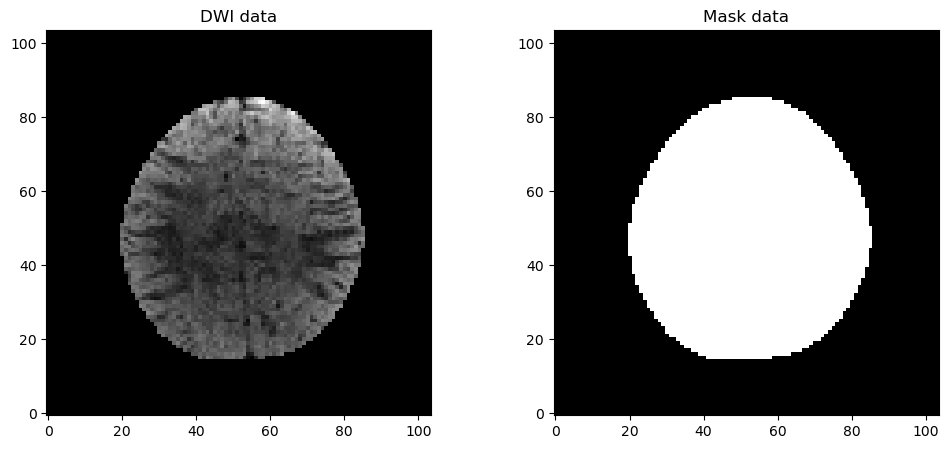

In [10]:

# Lets look a the data. 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow((sub01_dwi_data[:, :, 50, 1].astype('float')).T, cmap='gray', origin='lower')
ax[0].set_title('DWI data')

ax[1].imshow((sub01_dwi_mask[:, :, 50].astype('float')).T, cmap='gray', origin='lower')
ax[1].set_title('Mask data')

In [11]:
# Creat tensor model object and fit to the data.
sub01_dti_model = dti.TensorModel(sub01_gtab)
sub01_dti_fit = sub01_dti_model.fit(sub01_dwi_data, mask=sub01_dwi_mask, ) 

sub01_dti_fit

Text(0.5, 1.0, 'EVECS data')

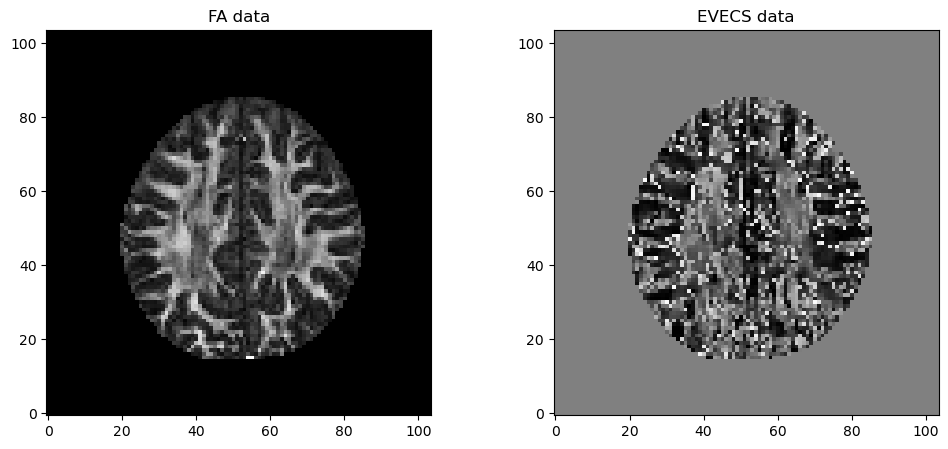

In [12]:
# Get FA and EVECS data.
sub01_fa_img = sub01_dti_fit.fa
sub01_evecs_img = sub01_dti_fit.evecs

# Turn nans to 0. 
sub01_fa_img[np.isnan(sub01_fa_img)] = 0

# Turn FA into nifti object.
fa_nii = nib.Nifti1Image(sub01_fa_img.astype(np.float32), dwi_affine)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow((sub01_fa_img[:, :, 50].astype('float')).T, cmap='gray', origin='lower')
ax[0].set_title('FA data')

ax[1].imshow((sub01_evecs_img[:, :, 50, 0, 0].astype('float')).T, cmap='gray', origin='lower')
ax[1].set_title('EVECS data')


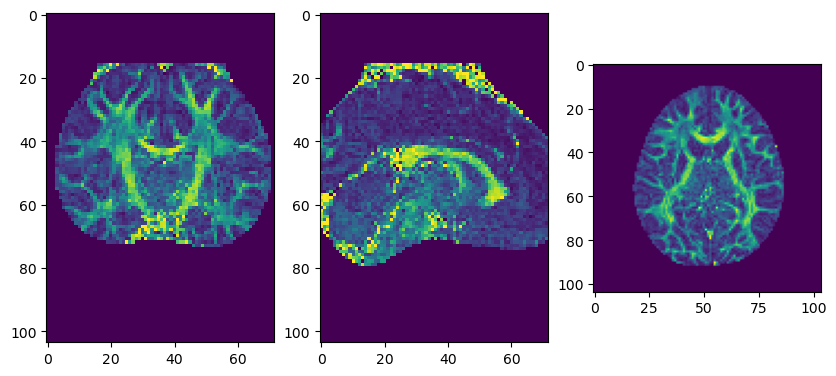

In [13]:
# Nicer image for FA data. 

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(ndimage.rotate(sub01_fa_img[:, sub01_fa_img.shape[1]//2, :], 90, reshape=False))
ax[1].imshow(ndimage.rotate(sub01_fa_img[sub01_fa_img.shape[0]//2, :, :], 90, reshape=False))
ax[2].imshow(ndimage.rotate(sub01_fa_img[:, :, sub01_fa_img.shape[-1]//2], 90, reshape=False))
plt.show()

In [14]:

# Get sphere object.
sphere = get_sphere('symmetric362')

# Get peaks from model.
peak_indices = peaks_from_model(
    model=sub01_dti_model, data=sub01_dwi_data, sphere=sphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=sub01_dwi_mask, npeaks=2)


In [15]:
# Define stopping criterion.
stopping_criterion = ThresholdStoppingCriterion(sub01_fa_img, .2)

# Copy seed mask and binarize it?
seed_mask = sub01_fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=dwi_affine, density=1)

# Initialize local tracking - computation happens in the next step.
streamlines_generator = LocalTracking(
    peak_indices, stopping_criterion, seeds, affine=dwi_affine, step_size=.5)

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

In [ ]:
# Figure is too heavy.
#sft = StatefulTractogram(streamlines, dwi_nii, Space.RASMM)

# Build the representation of the data
#streamlines_actor = actor.line(streamlines, colormap.line_colors(streamlines))

# Generate the figure
#fig = generate_anatomical_volume_figure(streamlines_actor, viewsize=(100, 100), figsize=(5, 5))

#plt.show()